# I. import all dependencies 

In [64]:
pip install pydot graphviz

   ---------------------------------------- 0.0/47.1 kB ? eta -:--:--
   ---------------------------------- ----- 41.0/47.1 kB 991.0 kB/s eta 0:00:01
   ---------------------------------------- 47.1/47.1 kB 1.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [56]:
import os
import numpy as np
import cv2
from glob import glob #retrieve files or directories matching a specified pattern
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard, EarlyStopping
from tensorflow.keras.metrics import MeanIoU

In [2]:
tf.__version__

'2.16.1'

# II. Set all the constants and paths

**Image Dimensions**

In [50]:
H=256
W=256
image_size=(H,W)
batch=4

**Directory paths**

In [4]:
train_image_dir =r'C:\Users\Lenovo\Downloads\SegSperm\AugmentedSegSperm\ground_truth'
train_mask_dir = r'C:\Users\Lenovo\Downloads\SegSperm\AugmentedSegSperm\binary_mask'

In [65]:
test_image_dir = r'C:\Users\Lenovo\Downloads\SegSperm\SegSperm\test\images'
test_mask_dir=r'C:\Users\Lenovo\Downloads\SegSperm\SegSperm\test\GT1_full'

# III. Prepare the dataset

##  1.Load Data Function

* The **load_data** function is designed to load image and mask file paths from specified directories, and then split them into training and validation sets. The function returns a tuple containing two tuples:

The first tuple contains **train_x and train_y** (list of file paths for training images and masks).

The second tuple contains **valid_x and valid_y** (list of file paths for validation images and masks).



In [5]:
def load_data(image_dir, mask_dir, split=0.2):
    
    #Step 1: Load and Sort Image and Mask Paths: we will collect all the png files in the same directory and the sorting will ensures that the images and masks are aligned correctly by their filenames
    images = sorted(glob(os.path.join(image_dir, "*.png")))
    masks = sorted(glob(os.path.join(mask_dir, "*.png")))

   
    # Step 2: Split Data into Training and Validation Sets
    train_x, valid_x, train_y, valid_y = train_test_split(images, masks, test_size=split, random_state=42)
    
    return (train_x, train_y), (valid_x, valid_y)

In [6]:
(train_x, train_y), (valid_x, valid_y) = load_data(train_image_dir, train_mask_dir)

In [7]:
type(train_x)

list

In [27]:
train_x[1]

'C:\\Users\\Lenovo\\Downloads\\SegSperm\\AugmentedSegSperm\\ground_truth\\302_rot_45.png'

In [9]:
(len(train_x),len( train_y))

(1382, 1382)

In [10]:
(len(valid_x),len(valid_y))

(346, 346)

## 2.Reading and processing an image

* **read_image** is used for reading the an image  file from the given path, resize it, normalize their pixel values and ensure it  has the correct shape for the model input

In [11]:
def read_image(path):
    
    #The path is passed as a byte string, so it needs to be decoded to a standard string format.
    path = path.decode()
    
    #read the image
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
    
    #Resizing
    x = cv2.resize(x, image_size)
    
    #Normalizing
    x = x / 255.0
    
    #convert to float32 to match expected inputr type for most deep learning models
    x = x.astype(np.float32)
    
    #Expand dimensions:This extra dimension represents the single channel (grayscale), making it compatible with models that expect a 3D input (height, width, channels).
    x = np.expand_dims(x, axis=-1)  # Add channel dimension
    
    return x

## 3. Creating a TensorFlow dataset pipeline

These functions streamline the process of preparing data for training deep learning models, ensuring efficient handling of image and mask pairs in tasks like semantic segmentation.







* **tf_parse** ensures that the preprocessing of images and masks becomes part of TensorFlow's computational graph. This integration ensures that the entire data pipeline, from data loading to model training, is optimized and efficient.

In [12]:
def tf_parse(x, y):
    
    def _parse(x, y):
        x = read_image(x)
        y = read_image(y)
        return x, y
    
    # Executes _parse as a TensorFlow operation
    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])#[tf.float32, tf.float32]: List of output types expected from _parse
   
    #Specifies the expected shape of x and y tensors after processing
    x.set_shape([H, W, 1])
    y.set_shape([H, W, 1])
    return x, y

* **tf_dataset Function** constructs a TensorFlow dataset pipeline by mapping tf_parse over image and mask paths, batching the data, and prefetching batches for efficiency.

In [13]:
def tf_dataset(X, Y, batch):
    
    # Step 1: Create a TensorFlow dataset from tensors X and Y
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    
    # Step 2: Apply tf_parse function to each element in the dataset
    dataset = dataset.map(tf_parse)
    
    # Step 3: Batch the dataset into batches of size 'batch'
    dataset = dataset.batch(batch)
    
    # Step 4: Prefetch data for efficient processing
    dataset = dataset.prefetch(10)
  
    return dataset

In [14]:
# Create TensorFlow datasets
train_dataset = tf_dataset(train_x, train_y, batch=4)
valid_dataset = tf_dataset(valid_x, valid_y, batch=4)

In [15]:
type(train_dataset)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [16]:
for batch in train_dataset.take(1):  # Take 1 batch for inspection
    images, masks = batch
    print("Batch shape - Images:", images.shape, "Masks:", masks.shape)

Batch shape - Images: (4, 256, 256, 1) Masks: (4, 256, 256, 1)


## 4. Visualization Function

In [17]:
def visualize_data(dataset, num_samples=5):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 5))
    
    for i, (images, masks) in enumerate(dataset.take(num_samples)):
        for j in range(len(images)):
            ax1 = axes[i, 0] if num_samples > 1 else axes[0]
            ax2 = axes[i, 1] if num_samples > 1 else axes[1]
            
            # Ensure images are squeezed and converted to numpy arrays
            image_np = images[j].numpy().squeeze()
            mask_np = masks[j].numpy().squeeze()
            
            ax1.imshow(image_np, cmap="gray")
            ax1.set_title("Image")
            ax1.axis("off")
            
            ax2.imshow(mask_np, cmap="gray")
            ax2.set_title("Mask")
            ax2.axis("off")
    
    plt.tight_layout()
    plt.show()

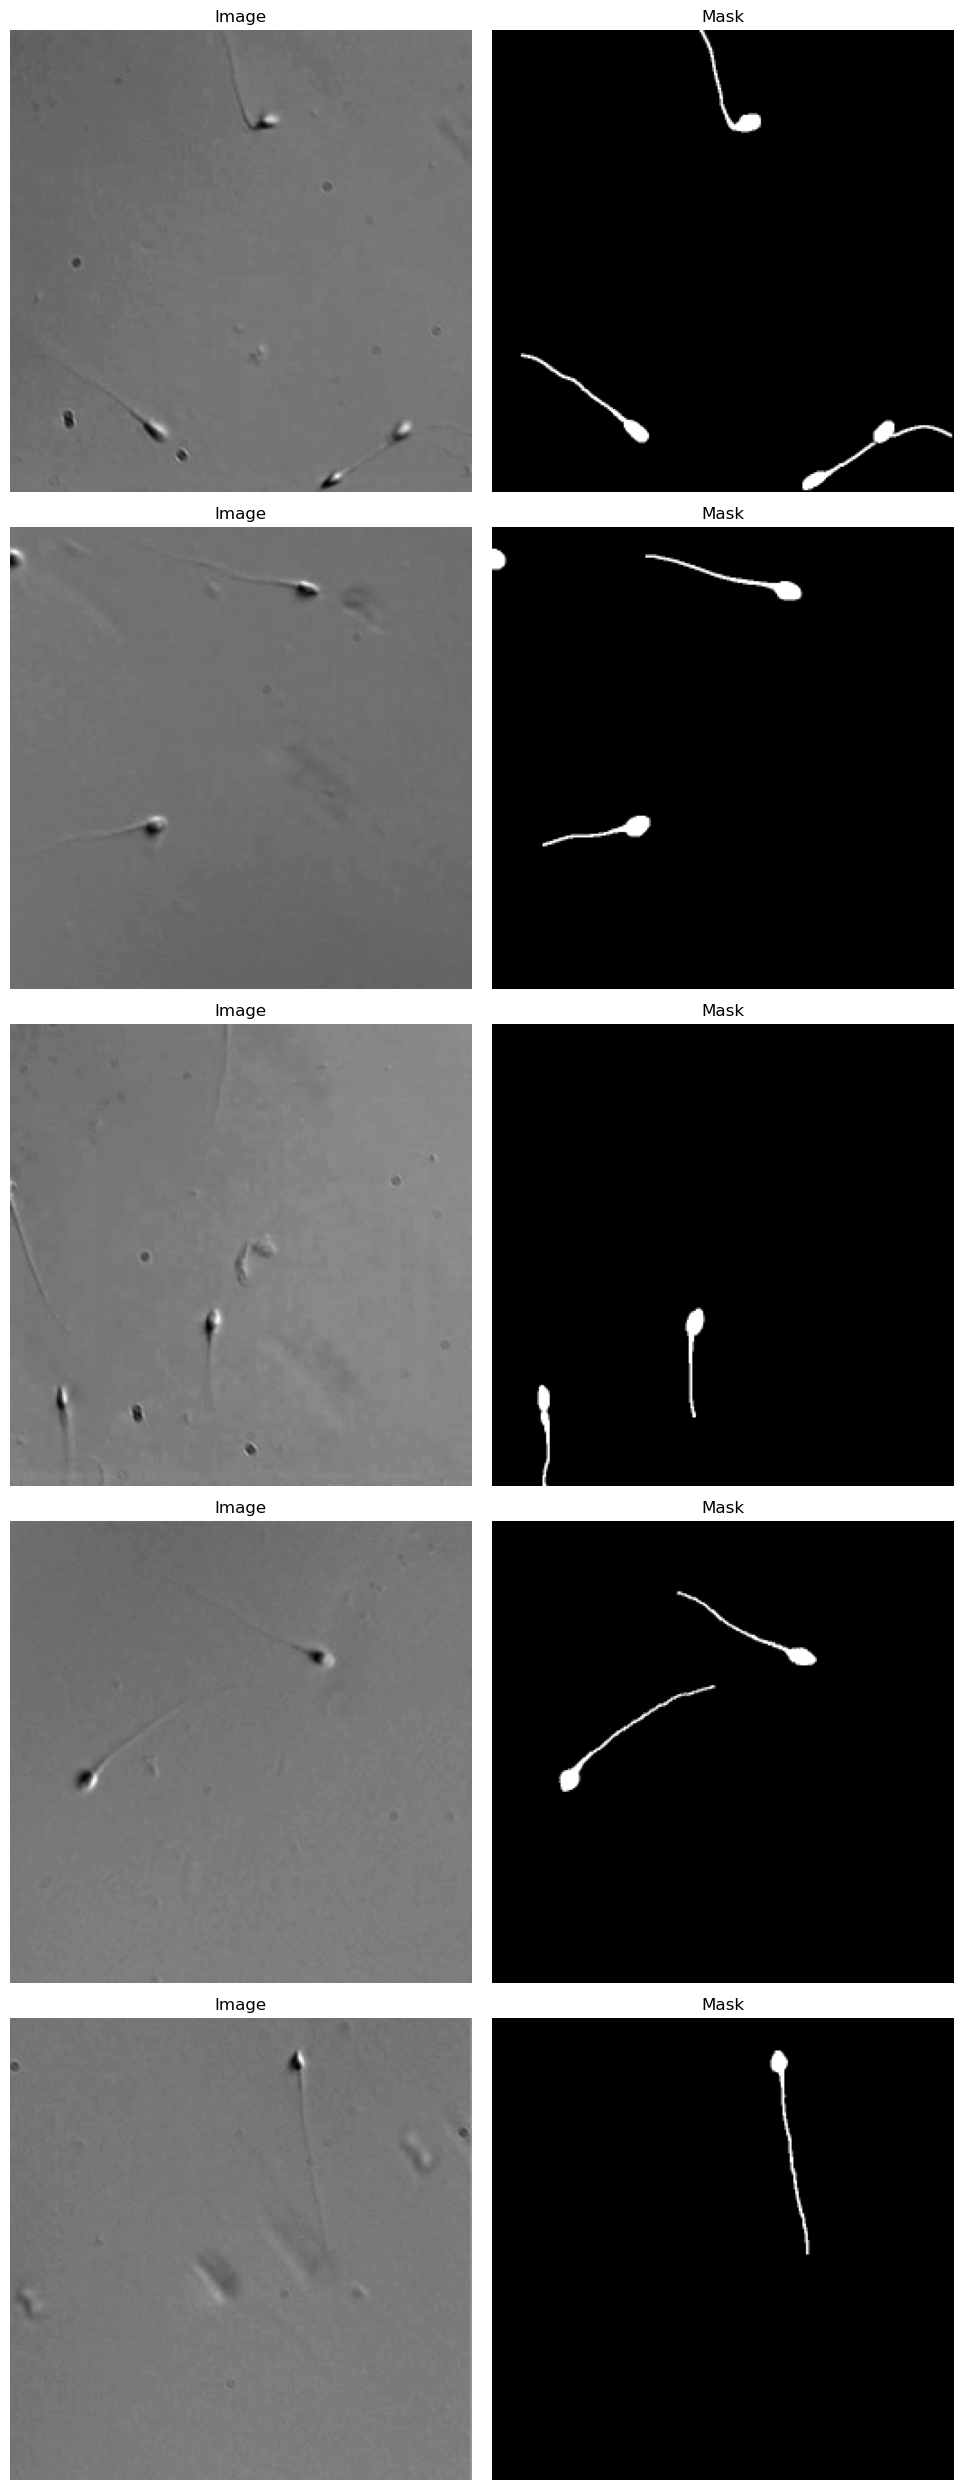

In [18]:
# Visualize some samples
visualize_data(train_dataset, num_samples=5)

# IV. U-Net Model Architecture

In [19]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    return x


In [20]:
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

In [21]:
def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [22]:
def build_microscopic_unet(input_shape):
    inputs = Input(input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bridge
    b1 = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Output
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    # Model
    model = Model(inputs, outputs)
    return model

In [24]:
input_shape = (256, 256, 1)  
model = build_microscopic_unet(input_shape)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 256, 256, 64)      │             640 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 256, 256, 64)      │             256 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 256, 256, 64)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 256, 256, 64)      │          36,928 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 256, 256, 64)      │             256 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 256, 256, 64)      │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 128, 128, 64)      │               0 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 128, 128, 128)     │          73,856 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 128, 128, 128)     │             512 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 128, 128, 128)     │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 128, 128, 128)     │         147,584 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 128, 128, 128)     │             512 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 128, 128, 128)     │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 64, 64, 128)       │               0 │ activation_3[0][0]         │
│ (MaxPooling2D)                │                           │               

 Total params: 31,054,145 (118.46 MB)

 Trainable params: 31,042,369 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

# V. Compile the Model

## 1. Compiling the Model

* for binary segmentation the binary cross-entropy loss is commonly used

* When dealing with image segmentation tasks, accuracy alone might not be sufficient to evaluate the model's performance effectively. While accuracy gives a general idea of how many pixels were correctly classified, it can be misleading, especially if the classes are imbalanced (e.g., background vs. objects).To provide a more comprehensive evaluation, you can consider additional metrics such as:

1. Intersection over Union (IoU): Also known as the Jaccard index, it measures the overlap between the predicted segmentation and the ground truth.

2. Dice Coefficient: Similar to IoU, it measures the similarity between two samples. It is especially useful for segmentation tasks.

3. Precision and Recall: These metrics help understand how well the model is performing in terms of detecting true positives and avoiding false positives and false negatives.

4. F1 Score: This is the harmonic mean of precision and recall and provides a single metric that balances the two.

In [30]:
# Define the Dice coefficient metric
def dice_coefficient(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1)


In [31]:
#Compile the model 
model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='binary_crossentropy', 
              metrics=['accuracy', MeanIoU(num_classes=2), dice_coefficient])

## 2. Training the model

* **Define Callbacks**

___ModelCheckpoint___:save the best model during training.

"unet_model.h5": This is the filename where the model will be saved.

monitor="val_loss": This specifies the metric to monitor. In this case, it is the validation loss.

save_best_only=True: This ensures that only the model with the best (lowest) validation loss is saved.

mode="min": This tells the callback that the monitored metric should be minimized. Since we are monitoring validation loss, we want to save the model with the lowest loss

In [33]:
checkpoint = ModelCheckpoint("unet_model.keras", 
                             monitor="val_loss",
                             save_best_only=True,
                             mode="min")

__EarlyStopping__ prevents overfitting and saves computational resources by stopping the training once the model's performance on the validation set stops improving.

In [34]:
early_stopping = EarlyStopping(monitor="val_loss", patience=20, mode="min")

__ReduceLROnPlateau__ Reduces the learning rate when a metric has stopped improving. This can help in fine-tuning the model and escaping potential local minima.

* monitor: The metric to be monitored.
* factor: The factor by which the learning rate will be reduced.
* patience: Number of epochs with no improvement after which learning  rate will be reduced.
* min_lr: The lower bound on the learning rate.
* verbose: If set to 1, logs the reduction process.


In [ ]:
ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1)

__TensorBoard()__  Provides visualization and monitoring of the training process using TensorBoard.Very useful for visualizing training metrics, model graphs, and other important aspects of the training process.


In [36]:
# Define file paths
model_path = "unet_model.keras"
csv_path = "training_log.csv"
log_dir = "./logs"  # Directory where the logs will be saved

# Define callbacks
callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path),
    TensorBoard(log_dir=log_dir),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
]

In [39]:

# Train the model
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=valid_dataset,
    callbacks=callbacks
)

Epoch 1/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9759 - dice_coefficient: 0.0618 - loss: 0.2020 - mean_io_u: 0.5159
Epoch 1: val_loss improved from inf to 0.08445, saving model to unet_model.keras
346/346 ━━━━━━━━━━━━━━━━━━━━ 1365s 4s/step - accuracy: 0.9760 - dice_coefficient: 0.0618 - loss: 0.2017 - mean_io_u: 0.5159 - val_accuracy: 0.9878 - val_dice_coefficient: 0.0213 - val_loss: 0.0844 - val_mean_io_u: 0.4964 - learning_rate: 1.0000e-04
Epoch 2/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9907 - dice_coefficient: 0.1336 - loss: 0.0660 - mean_io_u: 0.5254
Epoch 2: val_loss improved from 0.08445 to 0.06011, saving model to unet_model.keras
346/346 ━━━━━━━━━━━━━━━━━━━━ 1810s 5s/step - accuracy: 0.9907 - dice_coefficient: 0.1337 - loss: 0.0659 - mean_io_u: 0.5254 - val_accuracy: 0.9899 - val_dice_coefficient: 0.1137 - val_loss: 0.0601 - val_mean_io_u: 0.4972 - learning_rate: 1.0000e-04
Epoch 3/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9916 - 

Epoch 17/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9944 - dice_coefficient: 0.7747 - loss: 0.0068 - mean_io_u: 0.4968
Epoch 17: val_loss did not improve from 0.01287
346/346 ━━━━━━━━━━━━━━━━━━━━ 1349s 4s/step - accuracy: 0.9944 - dice_coefficient: 0.7747 - loss: 0.0068 - mean_io_u: 0.4968 - val_accuracy: 0.9927 - val_dice_coefficient: 0.6973 - val_loss: 0.0134 - val_mean_io_u: 0.4964 - learning_rate: 1.0000e-05
Epoch 18/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9945 - dice_coefficient: 0.7837 - loss: 0.0065 - mean_io_u: 0.4968
Epoch 18: val_loss did not improve from 0.01287
346/346 ━━━━━━━━━━━━━━━━━━━━ 1416s 4s/step - accuracy: 0.9945 - dice_coefficient: 0.7837 - loss: 0.0065 - mean_io_u: 0.4968 - val_accuracy: 0.9926 - val_dice_coefficient: 0.6996 - val_loss: 0.0138 - val_mean_io_u: 0.4964 - learning_rate: 1.0000e-05
Epoch 19/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9946 - dice_coefficient: 0.7919 - loss: 0.0063 - mean_io_u: 0.4968
Epoch 1

346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 134s/step - accuracy: 0.9947 - dice_coefficient: 0.8114 - loss: 0.0057 - mean_io_u: 0.4970  
Epoch 33: val_loss did not improve from 0.01287
346/346 ━━━━━━━━━━━━━━━━━━━━ 46264s 134s/step - accuracy: 0.9947 - dice_coefficient: 0.8114 - loss: 0.0057 - mean_io_u: 0.4970 - val_accuracy: 0.9927 - val_dice_coefficient: 0.7124 - val_loss: 0.0145 - val_mean_io_u: 0.4965 - learning_rate: 1.0000e-07
Epoch 34/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9947 - dice_coefficient: 0.8116 - loss: 0.0057 - mean_io_u: 0.4970 
Epoch 34: val_loss did not improve from 0.01287
346/346 ━━━━━━━━━━━━━━━━━━━━ 3986s 12s/step - accuracy: 0.9947 - dice_coefficient: 0.8116 - loss: 0.0057 - mean_io_u: 0.4970 - val_accuracy: 0.9927 - val_dice_coefficient: 0.7124 - val_loss: 0.0145 - val_mean_io_u: 0.4965 - learning_rate: 1.0000e-07
Epoch 35/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9947 - dice_coefficient: 0.8117 - loss: 0.0057 - mean_io_u: 0.4970
Epoch 35:

Due to the validation loss is not improving we can see that the model stopped training at epoch 35 instead of 50 epochs

## 3. Plotting metrics and loss curves

Let's understand how well the model trained and how it performed on the validation data

In [42]:
# Extract metrics from history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
mean_iou = history.history['mean_io_u']
val_mean_iou = history.history['val_mean_io_u']
dice_coef = history.history['dice_coefficient']
val_dice_coef = history.history['val_dice_coefficient']
loss = history.history['loss']
val_loss = history.history['val_loss']

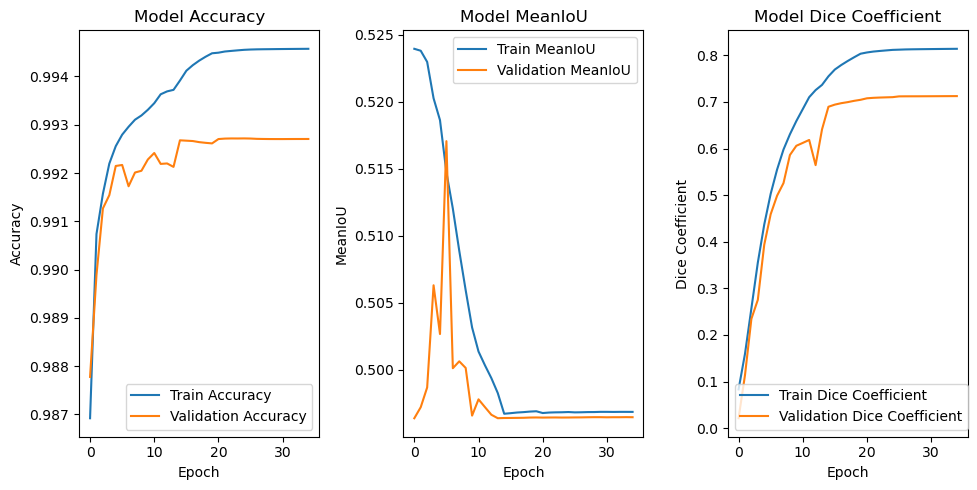

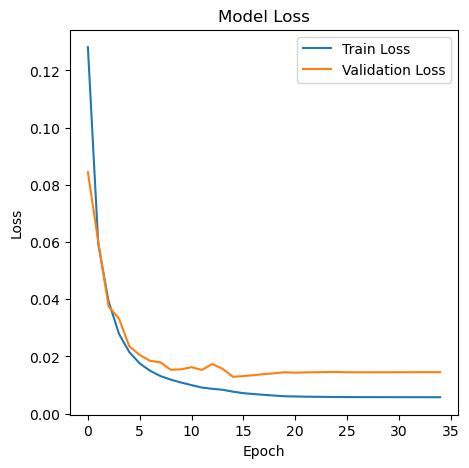

Final Training Accuracy: 0.9945738911628723
Final Training Loss: 0.005722129251807928
Final Validation Accuracy: 0.992705225944519
Final Validation Loss: 0.014486176893115044
Final Training MeanIoU: 0.49687066674232483
Final Validation MeanIoU: 0.49647393822669983
Final Training Dice Coefficient: 0.8139764070510864
Final Validation Dice Coefficient: 0.7125059366226196


In [48]:
# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.plot(accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot MeanIoU
plt.subplot(1, 3, 2)
plt.plot(mean_iou, label='Train MeanIoU')
plt.plot(val_mean_iou, label='Validation MeanIoU')
plt.title('Model MeanIoU')
plt.xlabel('Epoch')
plt.ylabel('MeanIoU')
plt.legend()

# Plot Dice Coefficient
plt.subplot(1, 3, 3)
plt.plot(dice_coef, label='Train Dice Coefficient')
plt.plot(val_dice_coef, label='Validation Dice Coefficient')
plt.title('Model Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()

plt.tight_layout()
plt.show()

# Plot Loss
plt.figure(figsize=(5, 5))
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Print final training and validation metrics
final_train_acc = history.history['accuracy'][-1]
final_train_loss = history.history['loss'][-1]
print(f"Final Training Accuracy: {final_train_acc}")
print(f"Final Training Loss: {final_train_loss}")

final_val_acc = history.history['val_accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]
print(f"Final Validation Accuracy: {final_val_acc}")
print(f"Final Validation Loss: {final_val_loss}")

final_mean_iou = history.history['mean_io_u'][-1]
final_val_mean_iou = history.history['val_mean_io_u'][-1]
print(f"Final Training MeanIoU: {final_mean_iou}")
print(f"Final Validation MeanIoU: {final_val_mean_iou}")

final_dice_coef = history.history['dice_coefficient'][-1]
final_val_dice_coef = history.history['val_dice_coefficient'][-1]
print(f"Final Training Dice Coefficient: {final_dice_coef}")
print(f"Final Validation Dice Coefficient: {final_val_dice_coef}")

* High Accuracy and Low Loss: Both training and validation accuracy are high, and both losses are low, indicating that the model is performing very well.

* Overfitting Check: The training accuracy and validation accuracy are very close (0.9946 vs. 0.9927), and similarly, the training loss and validation loss are also close (0.0057 vs. 0.0145). This small gap between training and validation metrics suggests that the model is not significantly overfitting to the training data. Overfitting occurs when a model performs well on training data but poorly on validation data

* MeanIoU (Intersection over Union): This metric evaluates the overlap between the predicted segmentation and the ground truth. A value of ~0.496 indicates that the model's predictions are about 50% accurate in terms of overlap. This is a moderate score and indicates room for improvement.
* Dice Coefficient: This is another measure of overlap, with a value of 1 indicating perfect overlap. Your training Dice Coefficient (~ 0.814) is higher than the validation Dice Coefficient (~ 0.713), which might suggest overfitting 

## 4. testing the model

In [66]:
#loading the paths of the testing data
test_images = sorted(glob(os.path.join(test_image_dir , "*.png")))
test_masks = sorted(glob(os.path.join(test_mask_dir, "*.png")))

In [67]:
# Function to load and preprocess images and masks
def load_and_preprocess_image(image_path, mask_path):
    image = load_img(image_path, target_size=image_size, color_mode="grayscale")
    image = img_to_array(image) / 255.0
    
    mask = load_img(mask_path, target_size=image_size, color_mode="grayscale")
    mask = img_to_array(mask) / 255.0
    
    return image, mask

In [68]:
# Load and preprocess test images and masks
test_images_array = []
test_masks_array = []

for image_path, mask_path in zip(test_images, test_masks):
    image, mask = load_and_preprocess_image(image_path, mask_path)
    test_images_array.append(image)
    test_masks_array.append(mask)


In [69]:
test_images_array = np.array(test_images_array)
test_masks_array = np.array(test_masks_array)

In [70]:
# Predict on test images
predictions = model.predict(test_images_array, batch_size=batch)


30/30 ━━━━━━━━━━━━━━━━━━━━ 27s 911ms/step


In [71]:
# Evaluate the model
test_loss, test_accuracy, test_mean_iou, test_dice_coefficient = model.evaluate(test_images_array, test_masks_array, batch_size=batch)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test MeanIoU: {test_mean_iou}")
print(f"Test Dice Coefficient: {test_dice_coefficient}")

30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 967ms/step - accuracy: 0.9934 - dice_coefficient: 0.4595 - loss: 0.0335 - mean_io_u: 0.4951
Test Loss: 0.038968391716480255
Test Accuracy: 0.9928259253501892
Test MeanIoU: 0.4952510595321655
Test Dice Coefficient: 0.3803497552871704


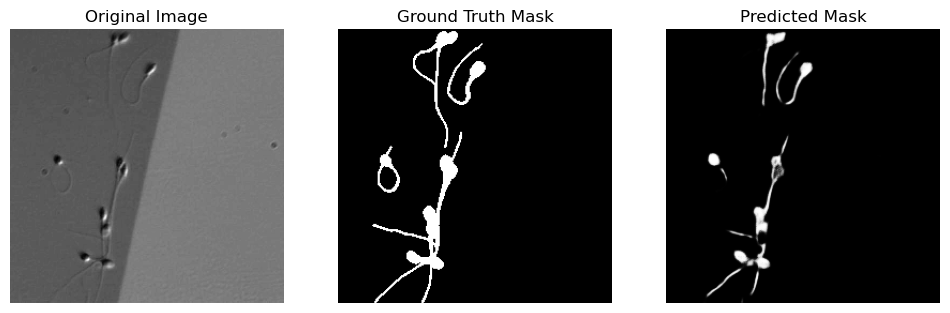

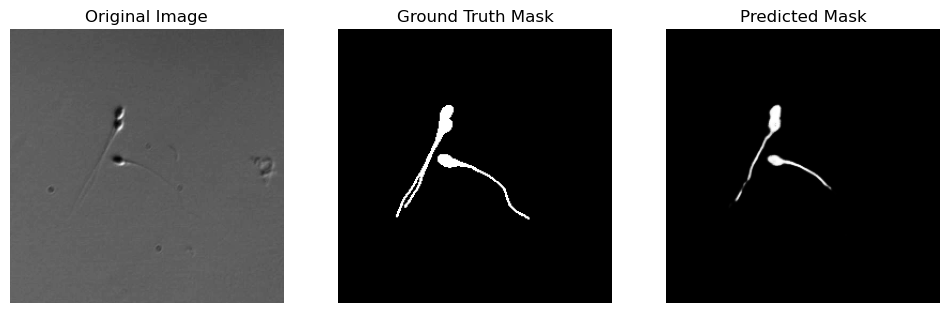

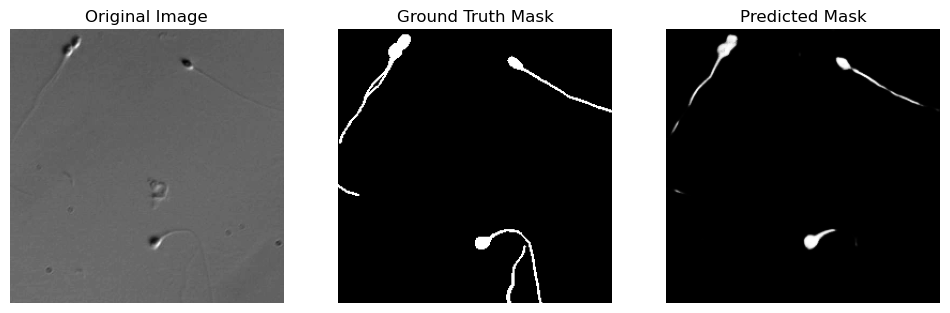

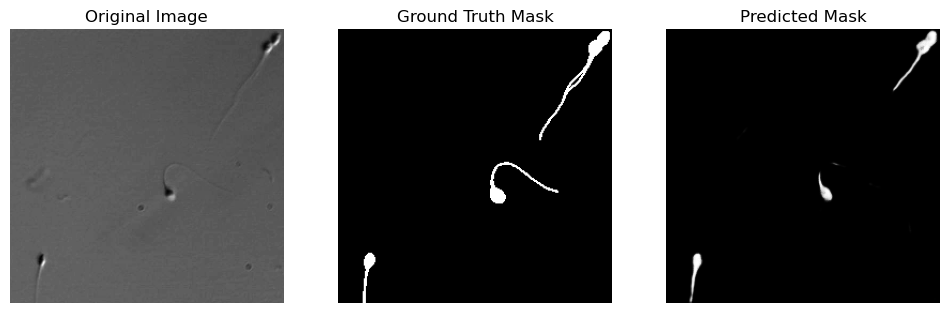

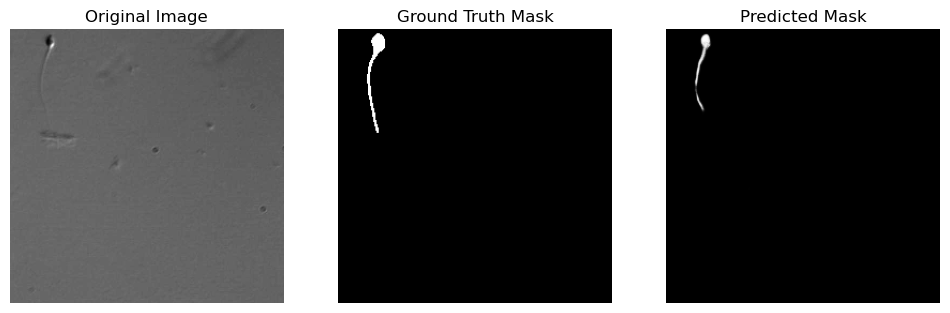

In [72]:
# Visualize predictions
num_samples = 5  # Number of samples to visualize
for i in range(num_samples):
    plt.figure(figsize=(12, 4))

    # Original image
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(test_images_array[i].squeeze(), cmap='gray')
    plt.axis('off')

    # Ground truth mask
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(test_masks_array[i].squeeze(), cmap='gray')
    plt.axis('off')

    # Predicted mask
    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(predictions[i].squeeze(), cmap='gray')
    plt.axis('off')

    plt.show()

* Test Loss: 0.03897 - This represents the average error between predicted and actual values. A lower value indicates better performance, but you should consider it in conjunction with other metrics.

* Test Accuracy: 0.9928 - This high accuracy suggests that the model correctly classifies a significant majority of pixels in the test dataset. However, accuracy alone can be misleading, especially in imbalanced datasets.

* Test Mean IoU: 0.4953 - The Intersection over Union (IoU) of approximately 0.495 indicates that the model's predicted segmentation overlaps about 50% with the ground truth. This is moderate, and there's potential for improvement.

* Test Dice Coefficient: 0.3803 - The Dice Coefficient of about 0.3803 indicates the degree of overlap between the predicted and actual segmentation. Since the value is below 0.5, it suggests that the model's predictions are not very accurate in terms of overlap.

Analysis:

* High Accuracy vs. Low IoU/Dice: The discrepancy between high accuracy and lower IoU/Dice suggests that while the model is classifying a lot of pixels correctly, it may struggle with precise boundary delineation or correctly identifying smaller segmented areas.

* Potential Overfitting: If your training metrics were significantly better than the test metrics, this could indicate overfitting, where the model performs well on training data but not on unseen data.

Next steps:

Model Tuning: Consider further tuning your model, which may include:
Adjusting hyperparameters.
Modifying the model architecture.
Employing data augmentation techniques to improve robustness.